# Import

In [ ]:
# Hugging Face tokenizers
from tokenizers import Tokenizer, decoders
from tokenizers.models import BPE, WordPiece
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase
from tokenizers.trainers import BpeTrainer, WordPieceTrainer
from tokenizers.processors import TemplateProcessing

# Word2vec
import gensim
from gensim.models import Word2Vec,KeyedVectors

# torch
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# RT

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1aW87J-D_gR8fMCWpBNZn-hxcQJYyIJp7/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1aW87J-D_gR8fMCWpBNZn-hxcQJYyIJp7
To: /content/RT.json
100% 397M/397M [00:07<00:00, 50.4MB/s]


In [ ]:
import re
from collections import Counter, defaultdict
from typing import Dict, Iterable, List, Tuple

import ipywidgets as widgets
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from ipywidgets import interact

In [ ]:
def has_text(message):
  return message['text']!= ''

In [ ]:
import json

def extract_text(message):
    result = ''
    for token in message['text']:
        if isinstance(token, dict):
            result += token['text']
        elif isinstance(token, str):
            result += token
    return result.strip()

def has_content(text, length = 5):
    return len(text.split()) >= length

def delete_spam(text, spam_words):
    for word in spam_words:
        text = text.replace(word, "")
    return text

def is_spam_text(text, spam_texts):
    for sequence in spam_texts:
        if text.find(sequence) != -1:
            return True
    return False

In [ ]:
file_name = 'RT.json'
data = pd.read_json(file_name)
data = data[data['messages'].apply(has_text)]['messages'].reset_index(drop=True)
texts = data.apply(extract_text).reset_index(drop=True)

In [ ]:
import re

def default_processing(text):
    text = text.replace("ё", "е")
    text = re.sub(r'https?:\/\/[^\s]+', 'www.russiatomorrow.com', text)
    text = re.sub(r'russian.rt.com\/[^\s\/]+', 'www.russiatomorrow.com', text)
    text = re.sub(r'@[^\s]+', '@russiatomorrow', text)
    text = re.sub(r'[«»"]', '', text)
    text = text.strip(':; ')
    text = text.lstrip('.: ')
    if text[-1] not in '!?.':
        text = text+'.'

    return text

In [ ]:
spam_words = ["@rt_russian", "🟩 Подпишись — RT на русском", "@RT_RUSSIA", "Ruptly"]
spam_texts = ["читайте в нашей подборке", "Подробнее — в видео", "Подпишись на канал", "Валентин Богданов", "ГОЛОВАНОВ", "оброе утро","обрый вечер", "в традиционной рубрике Бесит", "главные новости о", "Главные новости к"]
texts = texts.apply(lambda x: x.split("\n")).explode()
texts = texts.apply(lambda x: delete_spam(x, spam_words))
texts = texts[texts.apply(has_content)]
texts = texts[~texts.apply(lambda x: is_spam_text(x, spam_texts))]
texts = texts.apply(default_processing).reset_index(drop=True)

In [ ]:
texts = list(texts.values)

# Tokenizer

In [ ]:
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
trainer = WordPieceTrainer(special_tokens=["[UNK]","[EOS]"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.normalizer = Lowercase()

In [ ]:
tokenizer.train_from_iterator(texts, trainer=trainer)
tokenizer.decoder = decoders.WordPiece()

In [ ]:
tokenizer.post_processor = TemplateProcessing(
    single="$A [EOS]",
    special_tokens=[
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

In [ ]:
tokenizer.decode(tokenizer.encode(texts[0]).ids)

'добрый день, дорогие читатели www. russiatomorrow. com мы открыли этот канал в telegram, чтобы сообщать вам только о самом главном и интересном утром, днем и вечером. поехали!'

In [ ]:
tokenizer.get_vocab_size()

30000

In [ ]:
tokenized_texts = [text.tokens for text in tokenizer.encode_batch(texts)]

In [ ]:
embedding_size = 512
word2vec = gensim.models.Word2Vec(
    tokenized_texts,
    vector_size=embedding_size,
    epochs = 10,
    min_count=1,
    window = 6,
    shrink_windows = 1
)

In [ ]:
word2vec.wv.most_similar('получается')

[('получилось', 0.6811118125915527),
 ('получится', 0.6306459307670593),
 ('бывает', 0.6276301741600037),
 ('скажешь', 0.5337451100349426),
 ('понимают', 0.52865070104599),
 ('случилось', 0.5233952403068542),
 ('поняли', 0.5232011079788208),
 ('неудивительно', 0.5223237872123718),
 ('понял', 0.5198220014572144),
 ('понимаешь', 0.5164682865142822)]

# Dataset

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts)

    def __getitem__(self, idx):
        vectorized_tokens = [word2vec.wv.get_vector(token) for token in self.tokenized_texts[idx]]
        return torch.tensor(np.stack(vectorized_tokens))

dataset = TextDataset(tokenized_texts)

import torch

def collate_fn(batch):
    sizes = torch.tensor([t.size(0) for t in batch]).to(device)
    max_size = torch.max(sizes)
    sample_size = batch[0].size()[1:]
    new_batch = torch.zeros(len(batch), max_size, *sample_size)

    for i, t in enumerate(batch):
        new_batch[i, :sizes[i]] = t
    return new_batch, sizes


In [ ]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn,drop_last= True)

# RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.x2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=False)
        self.h2y = nn.Linear(hidden_size, out_size, bias = False)
        self.f = nn.Tanh()

    def forward(self, x, actual_sequence_lens):
        # x : (batch_size, seq, input_size)
        batch_size = x.size(0)
        sequence_size = x.size(1)

        out = torch.zeros(batch_size,sequence_size, self.out_size).to(device)
        hidden = torch.zeros(batch_size, sequence_size + 1, self.hidden_size).to(device)
        for t in range(sequence_size):
            mask = actual_sequence_lens > t
            hidden[mask, t] = self.f(self.h2h(hidden[mask, t-1]) + self.x2h(x[mask, t]))
            out[mask, t] = self.h2y(hidden[mask, t])

        return out, hidden

    @torch.no_grad()
    def single_forward(self, x, hidden):
        new_hidden = self.f(self.h2h(hidden) + self.x2h(x))
        out = self.h2y(new_hidden)
        return out, new_hidden


In [ ]:
model = RNN(input_size = embedding_size, hidden_size = 4 * embedding_size, out_size = embedding_size).to(device)

In [ ]:
criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 1
model.train()
losses = []
for epoch in range(num_epochs):
    for x, sizes in tqdm.tqdm(dataloader):
        x = x.to(device)
        predictions, _ = model(x, sizes)
        x = x[:,1:,:].reshape(-1, embedding_size)
        predictions = predictions[:,:-1,:].reshape(-1, embedding_size)
        labels = torch.ones(x.shape[0]).to(device)
        loss = criterion(x, predictions, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  8%|▊         | 2330/28948 [19:18<3:40:34,  2.01it/s]


KeyboardInterrupt: ignored

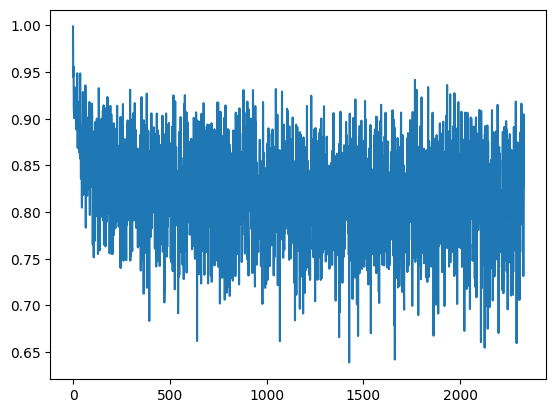

In [ ]:
plt.plot(losses)

In [ ]:
tokenized_texts[-16]

['в',
 'одессе',
 'произошли',
 'взрывы',
 ',',
 'передают',
 'украинские',
 'сми',
 '.',
 'ранее',
 'в',
 'области',
 'объявили',
 'воздушную',
 'тревогу',
 '.',
 '[EOS]']

In [ ]:
def generate_text(promt, max_tokens = 20):
    sent = []
    tokens = tokenizer.encode(promt).tokens
    embds = [torch.tensor(word2vec.wv.get_vector(token)) for token in tokens if word2vec.wv.has_index_for(token)]
    embds = torch.stack(embds[:-1]).to(device)
    out, hidden = model(torch.unsqueeze(embds,0), torch.tensor([embds.size(0)]))
    out = out[0, -1]
    out=word2vec.wv.index_to_key[np.argmin(word2vec.wv.distances(out.detach().cpu().numpy()))]
    sent.append(out)
    out = torch.tensor(word2vec.wv.get_vector(out))
    hidden = hidden[0,-1]
    for i in range(max_tokens):
        out, hidden = model.single_forward(out, hidden)
        out=word2vec.wv.index_to_key[np.argmin(word2vec.wv.distances(out.detach().cpu().numpy()))]
        sent.append(out)
        if out == '[EOS]':
            break
        out = torch.tensor(word2vec.wv.get_vector(out))
    return sent

In [ ]:
generate_text("в одессе произошли")

TypeError: ignored

# RNN with softmax

In [ ]:
model = RNN(input_size = embedding_size, hidden_size = 4 * embedding_size, out_size = tokenizer.get_vocab_size()).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 1
model.train()
losses = []
for epoch in range(num_epochs):
    for x, sizes in tqdm.tqdm(dataloader):
        x = x.to(device)
        predictions, _ = model(x, sizes)
        x = x[:,1:,:]
        predictions = predictions[:,:-1,:]
        loss = criterion(x, predictions)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/7237 [00:15<?, ?it/s]


RuntimeError: ignored

In [ ]:
plt.plot(losses)

In [ ]:
def generate_text(promt, max_tokens = 20):
    sent = []
    tokens = tokenizer.encode(promt).tokens
    embds = [torch.tensor(word2vec.wv.get_vector(token)) for token in tokens if word2vec.wv.has_index_for(token)]
    embds = torch.stack(embds[:-1]).to(device)
    out, hidden = model(torch.unsqueeze(embds,0), torch.tensor([embds.size(0)]))
    out = out[0, -1]
    out=word2vec.wv.index_to_key[np.argmin(word2vec.wv.distances(out.detach().cpu().numpy()))]
    sent.append(out)
    out = torch.tensor(word2vec.wv.get_vector(out))
    hidden = hidden[0,-1]
    for i in range(max_tokens):
        out, hidden = model.single_forward(out, hidden)
        out=word2vec.wv.index_to_key[np.argmin(word2vec.wv.distances(out.detach().cpu().numpy()))]
        sent.append(out)
        if out == '[EOS]':
            break
        out = torch.tensor(word2vec.wv.get_vector(out))
    return sent

In [ ]:
generate_text("в одессе произошли")

#LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.out_size = out_size

        self.x2i = nn.Linear(input_size, hidden_size)
        self.h2i = nn.Linear(hidden_size, hidden_size, bias=False)
        self.p2i = nn.Linear(hidden_size, hidden_size, bias=False)

        self.x2f = nn.Linear(input_size, hidden_size)
        self.h2f = nn.Linear(hidden_size, hidden_size, bias=False)
        self.p2f = nn.Linear(hidden_size, hidden_size, bias=False)

        self.x2o = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, hidden_size, bias = False)
        self.p2o = nn.Linear(hidden_size, hidden_size, bias=False)

        self.x2c = nn.Linear(input_size, hidden_size)
        self.h2c = nn.Linear(hidden_size, hidden_size, bias = False)

        self.h2y = nn.Linear(hidden_size, out_size)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, actual_sequence_lens):
        # x : (batch_size, seq, input_size)
        batch_size = x.size(0)
        sequence_size = x.size(1)

        out = torch.zeros_like(x).to(device)
        hidden = torch.zeros(batch_size, sequence_size + 1, self.hidden_size).to(device)
        c = torch.ones(batch_size, self.hidden_size).to(device)
        for t in range(sequence_size):
            mask = actual_sequence_lens > t
            i = self.sigmoid(self.x2i(x[mask, t])+self.h2i(hidden[mask, t-1])+self.p2i(c[mask]))
            f = self.sigmoid(self.x2f(x[mask, t])+self.h2f(hidden[mask, t-1])+self.p2f(c[mask]))
            o = self.sigmoid(self.x2o(x[mask, t])+self.h2o(hidden[mask, t-1])+self.p2o(c[mask]))
            c_ = self.tanh(self.x2c(x[mask, t])+self.h2c(hidden[mask, t-1]))
            c[mask] = f * c[mask] + i * c_
            hidden[mask, t] = o * c[mask]
            out[mask, t] = self.h2y(hidden[mask, t])

        return out, hidden, c

    @torch.no_grad()
    def single_forward(self, x, hidden, c):
        i = self.sigmoid(self.x2i(x)+self.h2i(hidden)+self.p2i(c))
        f = self.sigmoid(self.x2f(x)+self.h2f(hidden)+self.p2f(c))
        o = self.sigmoid(self.x2o(x)+self.h2o(hidden)+self.p2o(c))
        c_ = self.tanh(self.x2c(x)+self.h2c(hidden))
        c = f * c + i * c_
        new_hidden = o * c
        out = self.h2y(new_hidden)
        return out, new_hidden, c

In [ ]:
model = LSTM(input_size = embedding_size, hidden_size = 16 * embedding_size, out_size = embedding_size).to(device)
criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
num_epochs = 1
model.train()
losses = []
for epoch in range(num_epochs):
    for x, sizes in tqdm.tqdm(dataloader):
        x = x.to(device)
        predictions, *_ = model(x, sizes)
        x = x[:,1:,:].reshape(-1, embedding_size)
        predictions = predictions[:,:-1,:].reshape(-1, embedding_size)
        labels = torch.ones(x.shape[0]).to(device)
        loss = criterion(x, predictions, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 6/7237 [00:23<8:58:54,  4.47s/it]

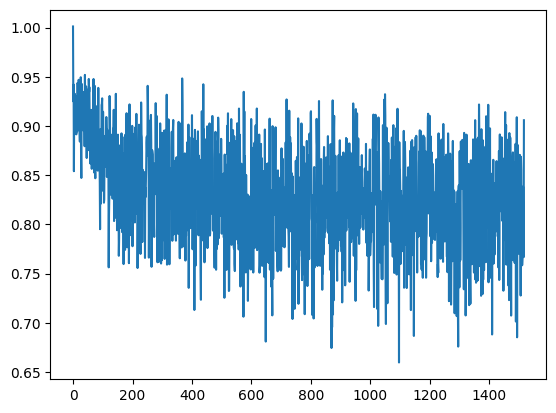

In [ ]:
plt.plot(losses)

In [ ]:
def generate_text(promt, max_tokens = 20):
    tokens = tokenizer.encode(promt).tokens
    sent = tokens
    embds = [torch.tensor(word2vec.wv.get_vector(token)) for token in tokens if word2vec.wv.has_index_for(token)]
    embds = torch.stack(embds[:-1]).to(device)
    out, hidden, c = model(torch.unsqueeze(embds,0), torch.tensor([embds.size(0)]))
    out = out[0, -1]
    out=word2vec.wv.index_to_key[np.argmin(word2vec.wv.distances(out.detach().cpu().numpy()))]
    sent.append(out)
    out = torch.tensor(word2vec.wv.get_vector(out)).to(device)
    hidden = hidden[0,-1]
    c = c[0].to(device)
    for i in range(max_tokens):
        out, hidden, c = model.single_forward(out, hidden, c)
        out=word2vec.wv.index_to_key[np.argmin(word2vec.wv.distances(out.detach().cpu().numpy()))]
        sent.append(out)
        if out == '[EOS]':
            break
        out = torch.tensor(word2vec.wv.get_vector(out)).to(device)
    return tokenizer.decode([tokenizer.token_to_id(token) for token in sent])

In [ ]:
generate_text("Когда")

'когда, наверное, вообще, вообще не получается, что реально реально реально, но не получается, что реально реально'

# Transformer

In [ ]:
from collections import namedtuple


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dimension = 120, n = 10):
        super().__init__()
        self.hidden_dimension = hidden_dimension
        self.n = n
        Head = namedtuple("Head", ("x2q", "x2k", "x2v", "projections"))
        self.heads = [
            Head(
                nn.Linear(hidden_dimension, hidden_dimension // n, bias = False),
                nn.Linear(hidden_dimension, hidden_dimension // n, bias = False),
                nn.Linear(hidden_dimension, hidden_dimension // n, bias = False),
                nn.Linear(hidden_dimension // n, hidden_dimension, bias = False),
            )
            for _ in range(n)
        ]

    def forward(self, x, l):
        attentions = []
        for i, head in enumerate(self.heads):
            a = head.x2q(x) @ head.x2k(x).mT
            attention = nn.functional.softmax(a / np.sqrt(self.hidden_dimension), dim=0) @ head.x2v(x)
            attention[:,l:,:] = torch.zeros_like(attention[:,l:,:])
            attention = head.projections(attention)
            attentions.append(attention)
        return torch.sum(torch.stack(attentions), dim=0)

In [ ]:
net = MultiHeadAttention()
x= torch.ones(32,100,120)
net(x, 1).shape

torch.Size([32, 100, 120])

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, input_size)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_dimension = 120, n = 10):
        super().__init__()
        self.hidden_dimension = hidden_dimension
        self.n = n
        self.layer_norm1 = nn.LayerNorm(hidden_dimension)
        self.multihead = MultiHeadAttention(hidden_dimension, n)
        self.layer_norm2 = nn.LayerNorm(hidden_dimension)
        self.feed_forward = FeedForward(hidden_dimension, hidden_dimension)

    def forward(self, x, l):
        x = self.multihead(self.layer_norm1(x), l) + x
        x = self.feed_forward(self.layer_norm2(x)) + x
        return x

In [ ]:
net = Decoder()
y = net(x, 2)
y.shape

torch.Size([32, 100, 120])

In [ ]:
class Transformer(nn.Module):
    def __init__(self, hidden_dimension = 512, n = 8):
        super().__init__()
        self.model = nn.Sequential(
            Decoder(hidden_dimension, n),
            Decoder(hidden_dimension, n),
            Decoder(hidden_dimension, n),
            Decoder(hidden_dimension, n),
            Decoder(hidden_dimension, n),
            Decoder(hidden_dimension, n),
            Decoder(hidden_dimension, n),
            Decoder(hidden_dimension, n),
        )

    def forward(self, x, actual_sequence_lens):
        # x : (batch_size, seq, input_size)
        batch_size = x.size(0)
        sequence_size = x.size(1)

        out = torch.zeros_like(x).to(device)
        hidden = torch.zeros(batch_size, sequence_size + 1, self.hidden_size).to(device)
        c = torch.ones(batch_size, self.hidden_size).to(device)

        self.model(x,l)
        for t in range(sequence_size):
            mask = actual_sequence_lens > t
            i = self.sigmoid(self.x2i(x[mask, t])+self.h2i(hidden[mask, t-1])+self.p2i(c[mask]))
            f = self.sigmoid(self.x2f(x[mask, t])+self.h2f(hidden[mask, t-1])+self.p2f(c[mask]))
            o = self.sigmoid(self.x2o(x[mask, t])+self.h2o(hidden[mask, t-1])+self.p2o(c[mask]))
            c_ = self.tanh(self.x2c(x[mask, t])+self.h2c(hidden[mask, t-1]))
            c[mask] = f * c[mask] + i * c_
            hidden[mask, t] = o * c[mask]
            out[mask, t] = self.h2y(hidden[mask, t])

        return out, hidden, c

    @torch.no_grad()
    def single_forward(self, x, hidden, c):
        i = self.sigmoid(self.x2i(x)+self.h2i(hidden)+self.p2i(c))
        f = self.sigmoid(self.x2f(x)+self.h2f(hidden)+self.p2f(c))
        o = self.sigmoid(self.x2o(x)+self.h2o(hidden)+self.p2o(c))
        c_ = self.tanh(self.x2c(x)+self.h2c(hidden))
        c = f * c + i * c_
        new_hidden = o * c
        out = self.h2y(new_hidden)
        return out, new_hidden, c